In [1]:
import warnings
import json
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import metrics
import numpy as np
import pandas as pd
import time

start_time = time.time()


warnings.filterwarnings('ignore')

df = pd.read_csv('../db/out/wta_s.csv')

In [2]:
df_2023 = df[df['date'].str.contains(
    '2023', na=False) | df['date'].str.contains('2022', na=False)]

df.drop(df_2023.index, inplace=True)

In [3]:
# normalizacja
non_numeric_columns = df.select_dtypes(['object']).columns

df_numeric_only = df.drop(non_numeric_columns, axis=1)

df = df_numeric_only

df = df.drop(['match_id'], axis=1)

df = df.fillna(df.median())


def normalize(dff):
    result = dff.copy()
    for feature_name in dff.columns:
        max_value = dff[feature_name].max()
        min_value = dff[feature_name].min()
        result[feature_name] = (
            dff[feature_name] - min_value) / (max_value - min_value)
    return result


df = normalize(df)
# df.info()
df = df.fillna(df.median())

In [4]:
non_numeric_columns = df_2023.select_dtypes(['object']).columns

df_numeric_only = df_2023.drop(non_numeric_columns, axis=1)

df_2023 = df_numeric_only

df_2023 = df_2023.drop(['match_id'], axis=1)

df_2023 = normalize(df_2023)

df_2023 = df_2023.fillna(df_2023.median())

y_2023 = pd.DataFrame(df_2023['y'])
x_2023 = df_2023.drop(['y'], axis=1)

In [5]:
# trining and testing
from sklearn.model_selection import train_test_split

Y = pd.DataFrame(df['y'])
df = df.drop(['y'], axis=1)
X = df
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=45, stratify=Y)

In [6]:
# Logistic regression Basic hiperparameters
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=45, n_jobs=-1)

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


basic_report = classification_report(y_test, y_pred, output_dict=True)
print("Trening")
print(basic_report)
basic_pre = basic_report['weighted avg']['precision']



pred_val = model.predict(x_2023)
basic_report = classification_report(y_2023, pred_val, output_dict=True)
print("Walidacja")
print(basic_report)
basic_pre_val = basic_report['weighted avg']['precision']

auc_basic = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[::, 1])
print("AUC: ", auc_basic)

auc_val = metrics.roc_auc_score(y_2023, model.predict_proba(x_2023)[::, 1])
print("AUC: ", auc_val)


# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# # cnf_matrix

# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# disp.plot()
# plt.ylabel('Wartosci prawdziwe')
# plt.xlabel('Predykcje')
# plt.grid(False)
# plt.show()

# basic_report = classification_report(y_test, y_pred, output_dict=True)

# y_pred_proba = result.predict_proba(X_test)[::, 1]
# fpr_basic, tpr_basic, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc_basic = metrics.roc_auc_score(y_test, y_pred_proba)
# print("AUC: ", auc_basic)

Trening
{'0.0': {'precision': 0.6703755215577191, 'recall': 0.6731843575418994, 'f1-score': 0.6717770034843207, 'support': 1432.0}, '1.0': {'precision': 0.6770186335403726, 'recall': 0.6742268041237114, 'f1-score': 0.6756198347107437, 'support': 1455.0}, 'accuracy': 0.6737097332871493, 'macro avg': {'precision': 0.6736970775490458, 'recall': 0.6737055808328054, 'f1-score': 0.6736984190975321, 'support': 2887.0}, 'weighted avg': {'precision': 0.6737235395468985, 'recall': 0.6737097332871493, 'f1-score': 0.6737137265305435, 'support': 2887.0}}
Walidacja
{'0.0': {'precision': 0.6081218274111675, 'recall': 0.8365921787709497, 'f1-score': 0.7042915931804821, 'support': 1432.0}, '1.0': {'precision': 0.735593220338983, 'recall': 0.45748418833450455, 'f1-score': 0.5641247833622183, 'support': 1423.0}, 'accuracy': 0.6476357267950963, 'macro avg': {'precision': 0.6718575238750752, 'recall': 0.6470381835527271, 'f1-score': 0.6342081882713502, 'support': 2855.0}, 'weighted avg': {'precision': 0.67

In [12]:
print(basic_pre_val)

0.6716566057426145


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
model = LogisticRegression(penalty='l1', random_state=45, n_jobs=-1)

param_grid = {
    'C': list(range(0, 15, 1)),
    'solver': ['liblinear', 'saga'],
    # 'solver': ['lbfgs', 'liblinear', 'sag', 'newton-cg', 'saga'],
}

search = GridSearchCV(model, param_grid,
                            cv=10, scoring='accuracy', n_jobs=-1, verbose=1)

result = search.fit(X_train, y_train)

print('Najlepszy wynik: %s' % result.best_score_)
print('Najlepsze hiperparametry: %s' % result.best_params_)

# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# # cnf_matrix

# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# disp.plot()
# plt.show()

# y_pred_proba = result.predict_proba(X_test)[::, 1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Najlepsza wynik: 0.6804840258037304
Najlepsze hiperparametry: {'C': 14, 'solver': 'saga'}


Optimal number of features : 24
                             Rank
win_percentage_vs               1
completeness                    1
serve_points_won                1
points_on_return                1
aceDf                           1
double_fault_probability        1
second_won_serve                1
first_won_serve                 1
bp_factor                       1
surface_wins                    1
win_percentage                  1
total_serve_points              1
games_played                    1
elo                             1
rank_points                     1
rank                            1
aceDf_vs                        1
double_fault_probability_vs     1
ace_probability_vs              1
second_won_serve_vs             1
first_won_serve_vs              1
bp_factor_vs                    1
ht                              1
ace_probability                 1
glicko                          2


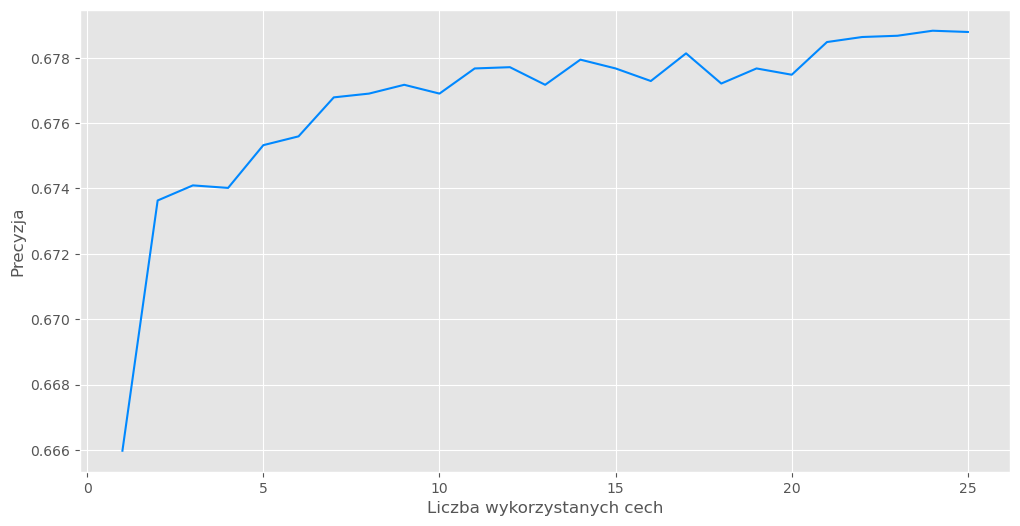

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      1432
         1.0       0.68      0.68      0.68      1455

    accuracy                           0.67      2887
   macro avg       0.67      0.67      0.67      2887
weighted avg       0.67      0.67      0.67      2887



In [8]:
from sklearn.inspection import DecisionBoundaryDisplay

model = LogisticRegression(C=6, solver='lbfgs', random_state=45)
cv = StratifiedKFold(3)

rfecv = RFECV(model, cv=cv, scoring='accuracy', step=1, n_jobs=-1)

rfecv.fit(X_train, y_train)

y_pred = rfecv.predict(X_test)

print('Optimal number of features : %d' % rfecv.n_features_)

ranks = pd.DataFrame(
    rfecv.ranking_, index=X.columns, columns=['Rank'])

print(ranks.sort_values(by='Rank', ascending=True))

selected_features = ranks[ranks['Rank'] == 1].index.values.tolist()

# rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_, index=X.columns, columns=[
#                                       'Rank']).sort_values(by='Rank', ascending=True)
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.xlabel('Liczba wykorzystanych cech')
plt.ylabel('Precyzja')
plt.plot(range(1, len(rfecv.cv_results_[
         "mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"],color='#0088ff')
plt.show()

print(classification_report(y_test, y_pred))



In [21]:
X = df[selected_features]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=45, stratify=Y)

In [9]:
model = LogisticRegression(C=6, solver='lbfgs', random_state=45)

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)



opti_report = classification_report(y_test, y_pred, output_dict=True)
print("Trening")
opti_pre = opti_report['weighted avg']['precision']
opti_f1 = opti_report['weighted avg']['f1-score']
opti_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[::, 1])



pred_val = model.predict(x_2023)
opti_val_report = classification_report(y_2023, pred_val, output_dict=True)
print("Walidacja")
print(opti_val_report)
opti_pre_val = opti_val_report['weighted avg']['precision']
opti_f1_val = opti_val_report['weighted avg']['f1-score']
opti_auc_val = metrics.roc_auc_score(y_2023, model.predict_proba(x_2023)[::, 1])



auc_basic = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[::, 1])
print("AUC: ", auc_basic)

auc_val = metrics.roc_auc_score(y_2023, model.predict_proba(x_2023)[::, 1])
print("AUC: ", auc_val)


# plt.grid(True)
# plt.plot(fpr, tpr, label="Regresja Logistyczna, auc="+str(auc), color='red')
# plt.plot(fpr_basic, tpr_basic, label="Regresja Logistyczna po optymalziacji, auc=" +
#          str(auc_basic), color='blue')
# plt.legend(loc=4)
# plt.show()

Trening
Walidacja
{'0.0': {'precision': 0.5920560747663551, 'recall': 0.8847765363128491, 'f1-score': 0.7094064949608063, 'support': 1432.0}, '1.0': {'precision': 0.7692307692307693, 'recall': 0.3865073787772312, 'f1-score': 0.5144995322731525, 'support': 1423.0}, 'accuracy': 0.6364273204903678, 'macro avg': {'precision': 0.6806434219985622, 'recall': 0.6356419575450402, 'f1-score': 0.6119530136169794, 'support': 2855.0}, 'weighted avg': {'precision': 0.6803641624100895, 'recall': 0.6364273204903678, 'f1-score': 0.6122602224898671, 'support': 2855.0}}
AUC:  0.7436301330415251
AUC:  0.723172677913135


In [10]:
import json

filename = 'results.json'

final_results = {
    "prediction_basic": basic_pre,
    "v_prcision_basic": basic_pre_val,
    "prediction_optimized": opti_pre,
    "v_prcision_optimized": opti_pre_val,
    "f1_score_opt": opti_f1,
    "f1_score_opt_val": opti_f1_val,
    "auc_opt": float(opti_auc),
    "auc_opt_val": float(opti_auc_val),
    "selected_features": selected_features,
}


with open(filename, 'r') as file:
    data = json.load(file)


data['Regresja logistyczna'] = (final_results)


with open('results.json', 'w') as file:
    json.dump(data, file, indent=4)